In [1]:
"""Tests for madi.utils.sample_utils."""

import madi.utils.sample_utils as sample_utils
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from pandas.testing import assert_series_equal
import pytest


class TestSampleUtilsTest:

  def test_get_pos_sample_synthetic(self):

    n_points = 10000
    df = sample_utils.get_pos_sample_synthetic(
        mean=[0, 1, 2], cov=np.eye(3), n_points=n_points)
    assert len(df) == n_points
    assert sorted(df.columns) == sorted(['class_label', 'x001', 'x002', 'x003'])

    assert np.mean(df['x001']) == pytest.approx(0.0, abs=1e-1)
    assert np.mean(df['x002']) == pytest.approx(1.0, abs=1e-1)
    assert np.mean(df['x003']) == pytest.approx(2.0, abs=1e-1)
    assert np.std(df['x001']) == pytest.approx(1.0, abs=1e-1)
    assert np.std(df['x002']) == pytest.approx(1.0, abs=1e-1)
    assert np.std(df['x003']) == pytest.approx(1.0, abs=1e-1)
    assert df['class_label'].all()

  def test_normalize_with_validity_indicator(self):

    n_points = 10000
    df_in = sample_utils.get_pos_sample_synthetic(
        mean=[0, 1, 2], cov=np.eye(3), n_points=n_points)
    df_in['x003_validity'] = np.concatenate(
        (np.ones(n_points - 100), np.zeros(100)), axis=0)
    normalization_info = sample_utils.get_normalization_info(
        df_in.drop(columns=['class_label']))

    df_normalized = sample_utils.normalize(df_in, normalization_info)
    assert sorted(normalization_info.keys()) == sorted(
        ['x001', 'x002', 'x003', 'x003_validity'])

    assert_series_equal(df_in['x003_validity'], df_normalized['x003_validity'])

  def test_get_column_order(self):
    n_points = 10000
    df_in = sample_utils.get_pos_sample_synthetic(
        mean=[0, 1, 2], cov=np.eye(3), n_points=n_points)
    df_in = df_in.drop(columns=['class_label'])
    # Get the normalization info from the data frame.
    normalization_info = sample_utils.get_normalization_info(df_in)
    column_order = sample_utils.get_column_order(normalization_info)
    assert column_order == ['x001', 'x002', 'x003']

  def test_normalization_denormalization(self):
    n_points = 10000
    df_in = sample_utils.get_pos_sample_synthetic(
        mean=[0, 1, 2], cov=np.eye(3), n_points=n_points)
    df_in = df_in.drop(columns=['class_label'])
    # Get the normalization info from the data frame.
    normalization_info = sample_utils.get_normalization_info(df_in)
    # Apply the normalization info on the data frame.
    df_normalized = sample_utils.normalize(df_in, normalization_info)
    # Now, use the nor malization info to recover the original data.
    df_out = sample_utils.denormalize(df_normalized, normalization_info)
    # Finally, make sure that the data is perfectly recovered.
    assert_frame_equal(df_in, df_out)

  def test_get_neg_sample(self):
    n_points = 10000
    df_pos = pd.DataFrame({
        'x001': [1, 1, 1, -1, -1, -1],
        'x002': [0.5, 0.5, 0.5, -1.5, -1.5, -1.5],
        'x003': [110, 110, 110, 90, 90, 90],
        'class_label': 1
    })
    df_neg = sample_utils.get_neg_sample(
        df_pos, n_points, do_permute=False, delta=0.05)
    assert len(df_neg) == n_points
    # dif = 20, 5% = 1: min should be one less, and max should be one more
    assert min(df_neg['x003']) == pytest.approx(89, abs=1e-1)
    assert max(df_neg['x003']) == pytest.approx(111, abs=1e-1)

  def test_get_positive_sample(self):
    df_raw = pd.DataFrame({
        'x001': [1, 1, 1, -1, -1, -1],
        'x002': [0.5, 0.5, 0.5, -1.5, -1.5, -1.5],
        'x003': [110, 110, 110, 90, 90, 90]
    })
    df_pos = sample_utils.get_pos_sample(df_raw, 3)
    assert len(df_pos) == 3
    assert df_pos['class_label'].all()

  def test_apply_negative_sample(self):

    positive_sample = pd.DataFrame({
        'x001': [-1.0, 0.0, -0.4, -0.5, -1.0],
        'x002': [67.0, 50.0, 98.0, 100.0, 77.0],
        'x003': [0.0001, 0.00011, 0.0008, 0.0009, 0.0005]
    })
    sample = sample_utils.apply_negative_sample(positive_sample, 10, 0.05)
    assert_series_equal(sample['class_label'].value_counts(),
                        pd.Series([50, 5], name='class_label', index=[0, 1]))
    assert min(sample['x001']) >= -1.05
    assert max(sample['x001']) <= 0.05
    assert min(sample['x002']) >= 47.5
    assert max(sample['x002']) <= 102.5
    assert min(sample['x003']) >= 6e-05
    assert max(sample['x003']) <= 0.00094

In [2]:
"""Tests for madi.utils.file_utils."""

import os
import pathlib
import textwrap

from madi.tests import test_data

from madi.utils import file_utils


class TestOpenTextResource:

  _FILE_CONTENTS = textwrap.dedent("""
  Lorem superposés valise pourparlers rêver chiots rendez-vous naissance Eiffel
  myrtille. Grèves Arc de Triomphe encore pourquoi sentiments baguette pédiluve
  une projet sentiments saperlipopette vachement le. Brume éphémère baguette
  Bordeaux en fait sommet avoir minitel.

  Nous avoir parole la nous moussant. Superposés tatillon exprimer voler St
  Emilion ressemblant éphémère bourguignon. Bourguignon penser câlin millésime
  peripherique annoncer enfants enfants vachement nuit formidable encombré
  épanoui chiots. Arc truc cacatoès lorem flâner.
  """)

  def _create_test_file(self, test_dir):
    temp_file = os.path.join(test_dir, "test_file.txt")
    with open(temp_file, "wt", encoding="utf-8") as f:
      f.write(self._FILE_CONTENTS)

    return temp_file

  def test_str_resource(self, tmpdir):
    test_file = self._create_test_file(tmpdir)
    with file_utils.open_text_resource(test_file) as f:
      test_contents = f.read()
      assert test_contents == self._FILE_CONTENTS

  def test_path_resource(self, tmpdir):
    test_file = pathlib.Path(self._create_test_file(tmpdir))
    with file_utils.open_text_resource(test_file) as f:
      test_contents = f.read()
      assert test_contents == self._FILE_CONTENTS

  def test_package_resource(self):
    package_resource = file_utils.PackageResource(test_data, "text_file.txt")

    expected = "testing"
    with file_utils.open_text_resource(package_resource) as f:
      test_contents = f.read()
      assert test_contents == expected


In [18]:
"""Tests for madi.utils.evaluation_utils."""


from madi.utils import evaluation_utils


class TestEvaluationUtils:

  def test_compute_auc_max(self):

    y_actual = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
    auc = evaluation_utils.compute_auc(y_actual, y_actual)
    assert auc == 1.0

  def test_compute_auc_min(self):
    y_actual = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
    y_predicted = [float(not bool(y)) for y in y_actual]
    auc = evaluation_utils.compute_auc(y_actual, y_predicted)
    assert auc == 0.0


In [3]:
"""Tests for madi.detectors.neg_sample_neural_net_detector."""
import os

from madi.datasets import positive_sample_dataset
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
import madi.tests.evaluation_utils_test as evaluation_utils


class TestNegSampleNeuralNetDetector:

  def test_gaussian_mixture(self, tmpdir):
    """Tests NS-NN on single-mode Gaussian."""

    log_dir = tmpdir
    split_ix = int(len(ds.sample) * 0.8)
    training_sample = ds.sample.iloc[:split_ix]
    test_sample = ds.sample.iloc[split_ix:]

    ad = NegativeSamplingNeuralNetworkAD(
        sample_ratio=3.0,
        sample_delta=0.05,
        batch_size=32,
        steps_per_epoch=16,
        epochs=20,
        dropout=0.5,
        layer_width=64,
        n_hidden_layers=2,
        log_dir=log_dir)

    ad.train_model(x_train=training_sample.drop(columns=['class_label']))

    y_actual = test_sample['class_label']
    xy_predicted = ad.predict(test_sample.drop(columns=['class_label']))

    auc = evaluation_utils.compute_auc(
        y_actual=y_actual, y_predicted=xy_predicted['class_prob'])

    assert auc > 0.98

  def test_gaussian_mixture_io(self, tmpdir):
    """Tests NS-NN on single-mode Gaussian."""

    model_dir = os.path.join(tmpdir, 'models')
    log_dir = os.path.join(tmpdir, 'logs')
    split_ix = int(len(ds.sample) * 0.8)
    training_sample = ds.sample.iloc[:split_ix]
    test_sample = ds.sample.iloc[split_ix:]

    # Train a new model.
    ad_in = NegativeSamplingNeuralNetworkAD(
        sample_ratio=3.0,
        sample_delta=0.05,
        batch_size=32,
        steps_per_epoch=16,
        epochs=20,
        dropout=0.5,
        layer_width=64,
        n_hidden_layers=2,
        log_dir=log_dir)

    ad_in.train_model(x_train=training_sample.drop(columns=['class_label']))

    # Save the model to model_dir.
    ad_in.save_model(model_dir)

    # Create a new model with the same parameters.
    ad_out = NegativeSamplingNeuralNetworkAD(
        sample_ratio=3.0,
        sample_delta=0.05,
        batch_size=32,
        steps_per_epoch=16,
        epochs=20,
        dropout=0.5,
        layer_width=64,
        n_hidden_layers=2,
        log_dir=log_dir)
    # Load the previous trained and saved model.
    ad_out.load_model(model_dir)

    # Get some predictions and ensure the loaded model predicts accurately.
    y_actual = test_sample['class_label']
    xy_predicted = ad_out.predict(test_sample.drop(columns=['class_label']))

    auc = evaluation_utils.compute_auc(
        y_actual=y_actual, y_predicted=xy_predicted['class_prob'])

    assert auc > 0.98

In [12]:
# Lint as: python3
#     Copyright 2020 Google LLC
#
#     Licensed under the Apache License, Version 2.0 (the "License");
#     you may not use this file except in compliance with the License.
#     You may obtain a copy of the License at
#
#         https://www.apache.org/licenses/LICENSE-2.0
#
#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.
"""Utility for variable attribution using Integrated Gradients."""
from typing import Tuple, Dict, Optional

from absl import logging
from madi.detectors.base_interpreter import BaseAnomalyInterpreter
import numpy as np
import pandas as pd
from scipy.spatial import distance
import tensorflow as tf

_CLASS_PROB_LABEL = 'class_prob'


class IntegratedGradientsInterpreter(BaseAnomalyInterpreter):
  """Utility for variable attribution using Integrated Gradients.

  Solution is based on Axiomatic Attribution for Deep Networks (2017),
  Sundararajan, M., Tuly, A., Yan, Q.
  https://drive.google.com/file/d/0B0ms91L2bD9GaFNaS19Ha1UxNzQ/view

  Given a reference point and a sample point of length N, we wish to determine
  the distance as the integral of gradients, from sample to reference.

  To compute the integral numerically, we compute and sum the integrals over an
  fixed number of steps between the two points for each variable. This solution
  is based on using the Keras optimization.get_gradients() method.

  The NN model trained to detect anomalies is queried for variable attribution.

  In this application, the baseline is the closest conformal point. The
  IG results which variable(s) caused the model to claim the point to be
  anomalous.
  """

  def __init__(self,
               model: tf.keras.Sequential,
               df_pos_normalized: pd.DataFrame,
               min_baseline_class_conf: float,
               baseline_size_limit: int,
               num_steps_integrated_gradients: int = 2000):
    """Constructs an interpreter based on integrated gradients.

    Args:
      model: tf.keras.Sequential model from NS-NN Anomaly Detector.
      df_pos_normalized: Dataframe with positive sample (normalized).
      min_baseline_class_conf: minimum classification score to be in baseline
      baseline_size_limit: choose the top confr that meet the min conf
      num_steps_integrated_gradients: number steps in integrated gradients.

    Raises:
      NoQualifyingBaselineError: if there are no points in the baseline, which
      provides the maximum confidence score.
    """

    # To compute integrated gradients we need a model.
    self._model = model
    self._num_steps_integrated_gradients = num_steps_integrated_gradients
    self._df_baseline, max_class_confidence = select_baseline(
        df_pos_normalized=df_pos_normalized,
        model=model,
        min_p=min_baseline_class_conf,
        max_count=baseline_size_limit)
    if self._df_baseline.empty:
      raise NoQualifyingBaselineError(min_baseline_class_conf,
                                      max_class_confidence)

    # Create a gradient tensor, where the loss tensor is the output, and the
    # list of variables (params) are the input.
    logging.info('Finished setting up IG.')

  def explain(self,
              sample: np.ndarray,
              reference: np.ndarray,
              num_steps: int = 50) -> (Tuple[np.ndarray, np.matrix]):
    """Returns variable attribution between sample and reference.

    Args:
      sample: normalized observed vector length N
      reference: normalized reference vector length N, as described in IG paper
      num_steps: number of steps to approximate the path integral between sample
        and reference.  Returns a normalized vector length N, that indicates
        magnitude of the variables in [-1, 1].
    """

    # Create the intermediate steps between sample and reference.
    interp_output = tf.convert_to_tensor(
        np.linspace(reference, sample, num_steps))
    with tf.GradientTape() as tape:
      tape.watch(interp_output)
      outs = self._model(interp_output)

    # Next compute and sum the gradients.
    gradients = tape.gradient(outs, interp_output)
    mat_grad = np.matrix(gradients)
    dif = np.array(reference - sample)

    # Integrated Gradients dif * grad_sum for each variable i:
    # ig_i = (x_i - x'_i) * integral over alpha from 0 to 1 on dF/dx_i(alpha)
    # where sample = x_i, reference  = x'_i, and alpha in [0, 1]
    grad_sum = np.array(mat_grad.sum(axis=0).tolist()[0])

    attribution = np.multiply(grad_sum, dif) / float(num_steps)
    denom = sum([abs(val) for val in attribution])
    logging.info('Sum of attributions %f', abs(sum(attribution)))

    # We've found it useful to noirmalize the the total attribution, A to
    # distribute the blame fully on the dimensions. In cases where the
    # the total attrbution by IG will sum to the difference between the
    # baseline and the observed point, which could be less than one. In order
    # to sum the blame to one across all dimensions, we divide by the sum.
    if denom == 0:
      return np.zeros(len(attribution)), mat_grad
    return attribution / denom, mat_grad

  def blame(
      self,
      observation_normalized: pd.Series,
  ) -> (Tuple[Dict[str, float], Dict[str, float], Optional[pd.DataFrame]]):
    """Performs variable attribution using a baseline and integrated grads.

    Args:
      observation_normalized: original feature names as cols and values.

    Returns:
      Attribution Dict with variable name key, and proportional blame as value
      Reference Dict: Nearest original baseline point with variable name as kay
      Gradiant Matrix useful to disply and understand the gradiants.
    """

    attribution_dict = {}
    reference_point_dict = {}

    observation_normalized_array = observation_normalized.to_numpy()
    # Pull out the point in the baseline sample.
    nearest_reference_index, _ = find_nearest_euclidean(
        self._df_baseline, observation_normalized_array)

    # Use the normalized reference point for integrated gradients.
    reference_point_normalized = self._df_baseline.loc[[
        nearest_reference_index
    ]]

    # Use integrated gradients to compute variable attribution info,
    # including reference point and integrated gradients attribution.
    explanation, mat_grad = self.explain(
        observation_normalized_array,
        reference_point_normalized.iloc[0].to_numpy(),
        num_steps=self._num_steps_integrated_gradients)

    df_grad = pd.DataFrame(mat_grad)

    # Attribution is the proportional explanation.
    attribution = [abs(v) for v in explanation]
    for i, column in enumerate(observation_normalized.index):
      attribution_dict[column] = attribution[i]
      reference_point_dict[column] = reference_point_normalized.iloc[0][column]

    return attribution_dict, reference_point_dict, df_grad


def find_nearest_euclidean(df_reference: pd.DataFrame,
                           example: np.ndarray) -> (Tuple[int, float]):
  """Returns index, dist from df_reference closest to example.

  Based on Section 3.2 (Interpreting Anomalies with Integrated Gradients)
  Interpretable, Multidimensional, Multimodal Anomaly Detection with Negative
  Sampling (Sipple 2020).

  Args:
    df_reference: baseline data set for anomaly detection.
    example: feature values of anomalous datapoint

  Returns:
    tuple with dataframe index of the neearest point and its Euclidian distance

  """
  for column in df_reference:
    if not np.issubdtype(df_reference[column].dtype, np.number):
      raise ValueError('The feature column %s is not numeric.' % column)
  if len(example) != df_reference.shape[1]:
    raise ValueError('Dimensionality is not the same: %d != %d' %
                     (df_reference.shape[1], len(example)))

  # Minor fix required to handle a pandas bug, adding v = example
  # Pandas issue: https://github.com/pandas-dev/pandas/issues/36948
  # and PR: https://github.com/pandas-dev/pandas/pull/36950
  distances = df_reference.agg(distance.euclidean, 1, v=example)
  nearest_ix = distances.idxmin()
  return nearest_ix, distances[nearest_ix]


def select_baseline(df_pos_normalized: pd.DataFrame,
                    model: tf.keras.Sequential,
                    min_p: float = 0.85,
                    max_count: int = 100):
  """Selects the representative subsamnple that will be used as baselines.

  Based on Proposition 3 (Baseline Set for Anomaly Detection) of
  Interpretable, Multidimensional, Multimodal Anomaly Detection with Negative
  Sampling (Sipple 2020).

  Args:
    df_pos_normalized: data frame of the normalized positive sample.
    model: classifier model from NS-NN.
    min_p: minimum class score to be be considered as a baseline normal.
    max_count: maximum number of reference points to be selected.

  Returns:
    data frame of the normalized baseline and the maximum conf score
  """
  x = np.float32(np.matrix(df_pos_normalized))
  y_hat = model.predict(x, verbose=1, steps=1)
  df_pos_normalized[_CLASS_PROB_LABEL] = y_hat
  high_scoring_predictions = df_pos_normalized[
      df_pos_normalized[_CLASS_PROB_LABEL] >= min_p]
  high_scoring_predictions = high_scoring_predictions.sort_values(
      by=_CLASS_PROB_LABEL, ascending=False)
  high_scoring_predictions = high_scoring_predictions.drop(
      columns=[_CLASS_PROB_LABEL])
  return high_scoring_predictions[:max_count], float(max(y_hat))


class Error(Exception):
  """Base class for exceptions in integrated gradiants interpreter."""
  pass


class NoQualifyingBaselineError(BaseException):
  """Exception rasied when there are no baseline points."""

  def __init__(self, min_class_confidence: float,
               highest_class_confidence: float):
    """Constructs an exception when there are no baseline points.

    Args:
      min_class_confidence: threshold set when constructing the interpreter
      highest_class_confidence: highest score the model produced on sample
    """
    super(NoQualifyingBaselineError, self).__init__(min_class_confidence,
                                                    highest_class_confidence)
    self.highest_class_confidence = highest_class_confidence
    self.min_class_confidence = min_class_confidence
    self.message = ('No positive sample points met the min_class_confidence '
                    '%3.2f. Highest class confidence is %3.2f') % (
                        min_class_confidence, highest_class_confidence)

In [1]:
#@title Colab Imports
import sys
import time
import madi
import os
from madi.utils import file_utils
from madi.tests import file_utils_test
import numpy as np
import pandas as pd
from typing import Tuple, List, Dict
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib as mpl
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

from madi.datasets import positive_sample_dataset
from madi.tests import gaussian_mixture_dataset_test
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
from madi.tests.neg_sample_neural_net_detector_test import TestNegSampleNeuralNetDetector
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter
from madi.tests.integrated_gradients_interpreter_test import TestIntegratedGradientsInterpreter

import tensorflow as tf
assert tf.version.VERSION > '2.1.0'

In [2]:
#@title Choose the data set
_RESOURCE_LOCATION = "madi.datasets.data"
data_source = "positive_sample" #@param ["gaussian_mixture", "smart_buildings"]
ds = None

class InvalidDatasetError(ValueError):
    pass

if data_source == 'positive_sample':
  
  data_file = file_utils.PackageResource(
      _RESOURCE_LOCATION, "positive_sample.csv")
  readme_file = file_utils.PackageResource(
      _RESOURCE_LOCATION, "positive_sample_README.md")
  ds = madi.datasets.positive_sample_dataset.PositiveSampleDataset(data_file, readme_file)
  print(ds.description)

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)


print('Randomize the data, and split into training and test sample.')
split_ix = int(len(ds.sample) * 0.8)
training_sample = ds.sample.iloc[:split_ix]
test_sample = ds.sample.iloc[split_ix:]
print("\tTraining sample size: %d" %len(training_sample))
print("\tTest sample size: %d" %len(test_sample))

The positive sample dataset consists of 4,032 multidimensional observations. 
 The dataset consists of 4032 rows and seven columns. 
 These are the test dataset that we will be using in this project.

Randomize the data, and split into training and test sample.
	Training sample size: 3225
	Test sample size: 807


In [3]:
#@title Reset Anomlay Detectors
ad_dict = {}
log_dir = "logs/nsnn2" #@param {type:"string"}

# Set up the logging directory.
os.makedirs(log_dir, exist_ok=True)


# Neg Sampling Neural Net Parameters
nsnn_params = {}


if data_source == 'positive_sample':

    nsnn_params['sample_ratio']=3.0
    nsnn_params['sample_delta']=0.05
    nsnn_params['batch_size']=32
    nsnn_params['steps_per_epoch']=16
    nsnn_params['epochs']=20
    nsnn_params['dropout']=0.5
    nsnn_params['layer_width']=64
    nsnn_params['n_hidden_layers']=2

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)

In [4]:
ad_dict['ns-nn'] = NegativeSamplingNeuralNetworkAD(
        sample_ratio=nsnn_params['sample_ratio'],
        sample_delta=nsnn_params['sample_delta'],
        batch_size=nsnn_params['batch_size'],
        steps_per_epoch=nsnn_params['steps_per_epoch'],
        epochs=nsnn_params['epochs'],
        dropout=nsnn_params['dropout'],
        layer_width=nsnn_params['layer_width'],
        n_hidden_layers=nsnn_params['n_hidden_layers'],
        log_dir=log_dir)

print('Anomaly Detectors: ', list(ad_dict))

Anomaly Detectors:  ['ns-nn']


1/1 [==============================] - 0s 62ms/step


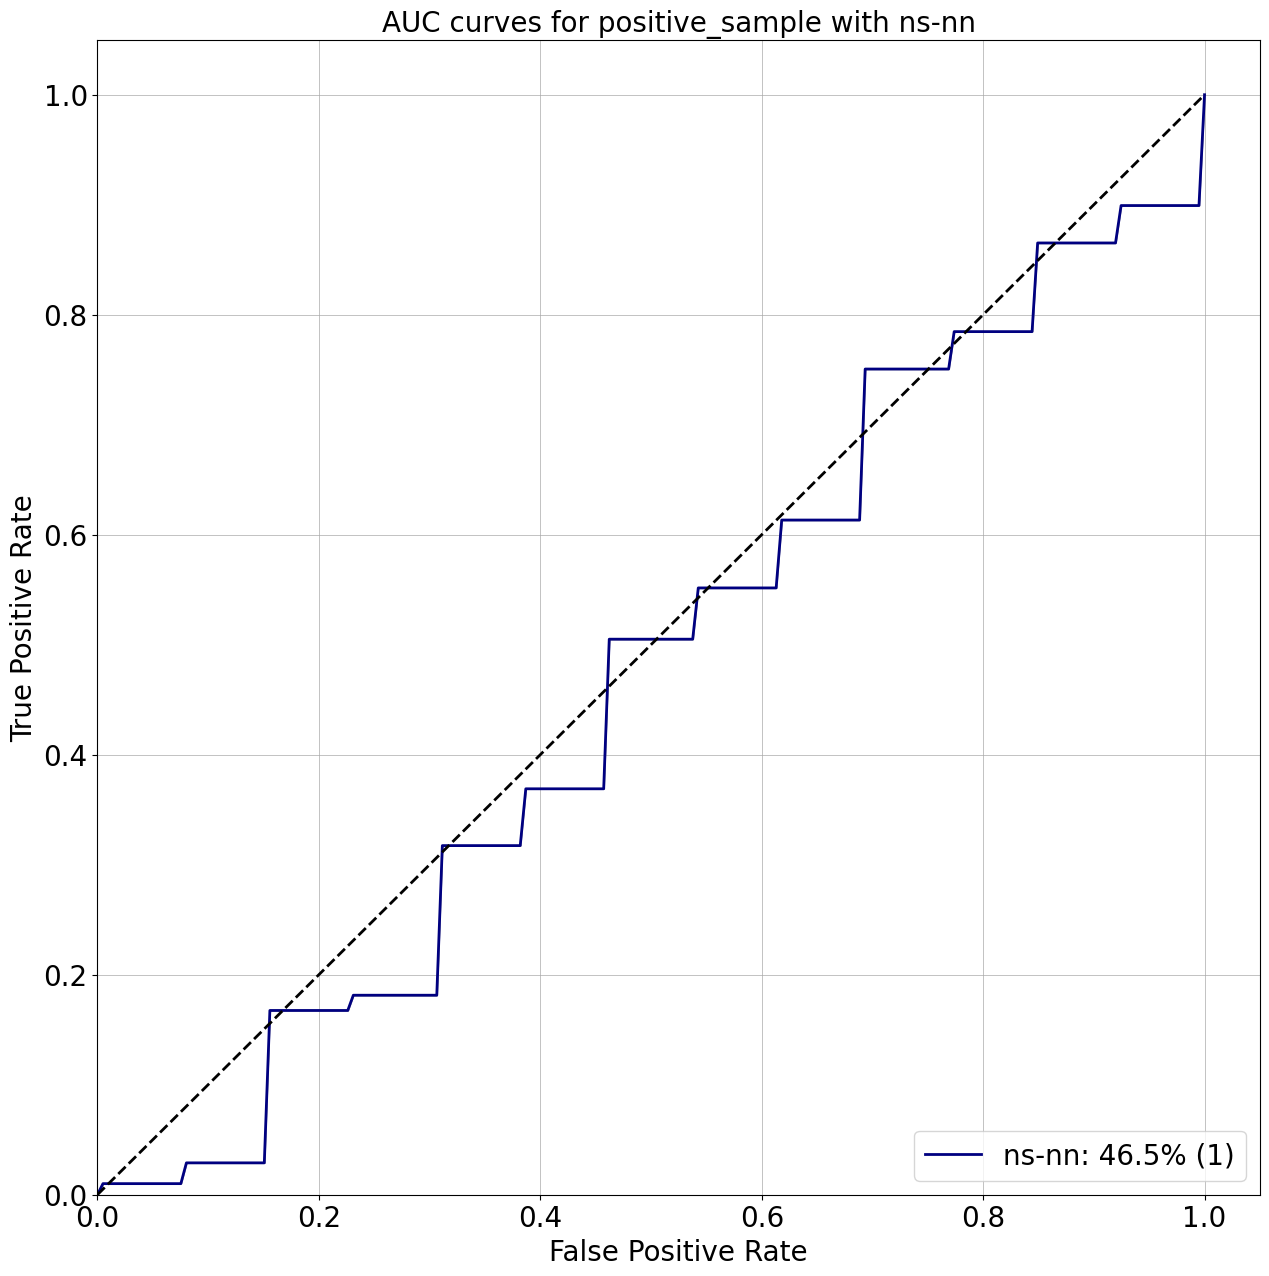

1/1 [==============================] - 0s 43ms/step


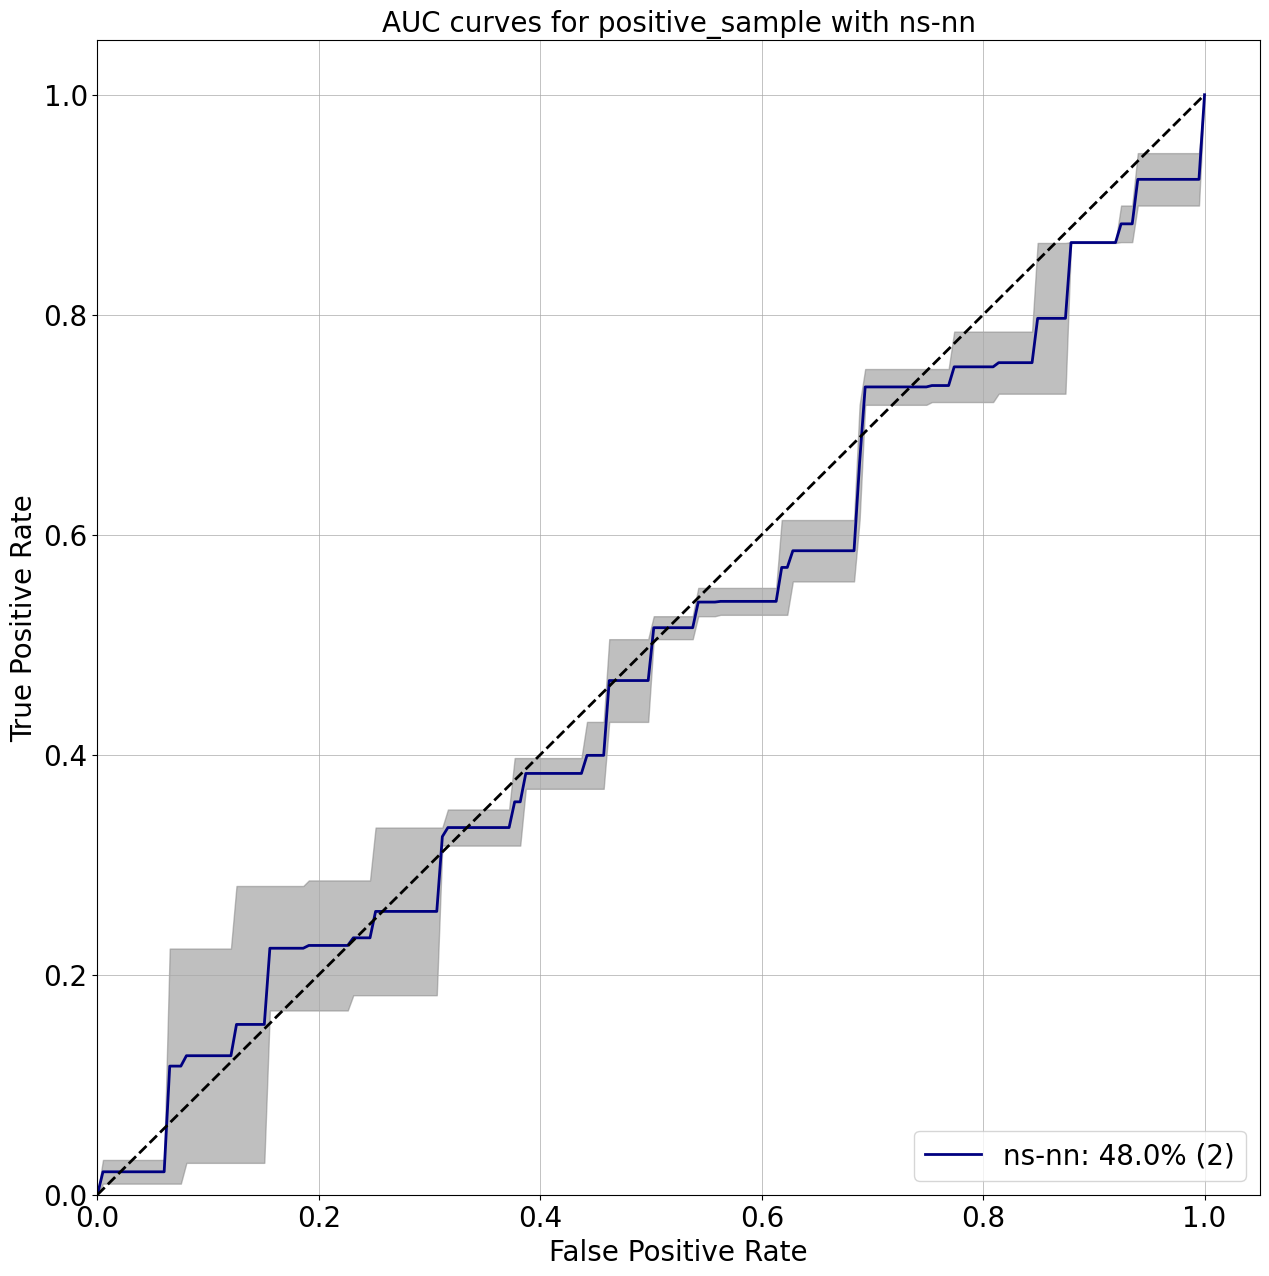

1/1 [==============================] - 0s 43ms/step


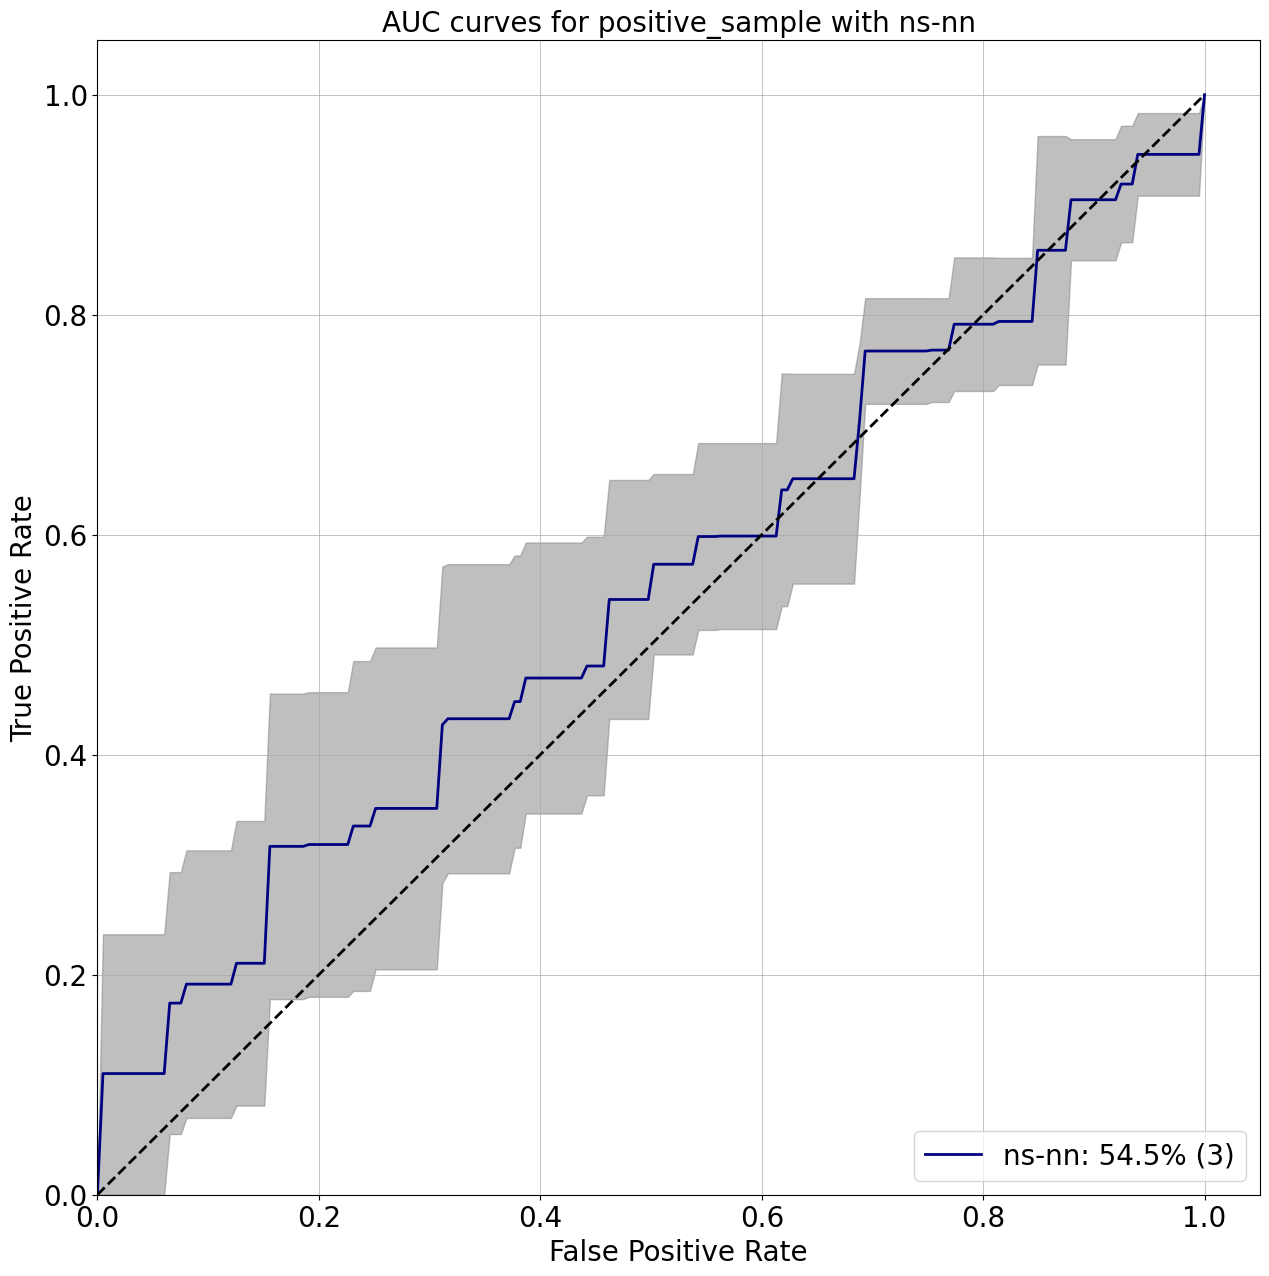

1/1 [==============================] - 0s 39ms/step


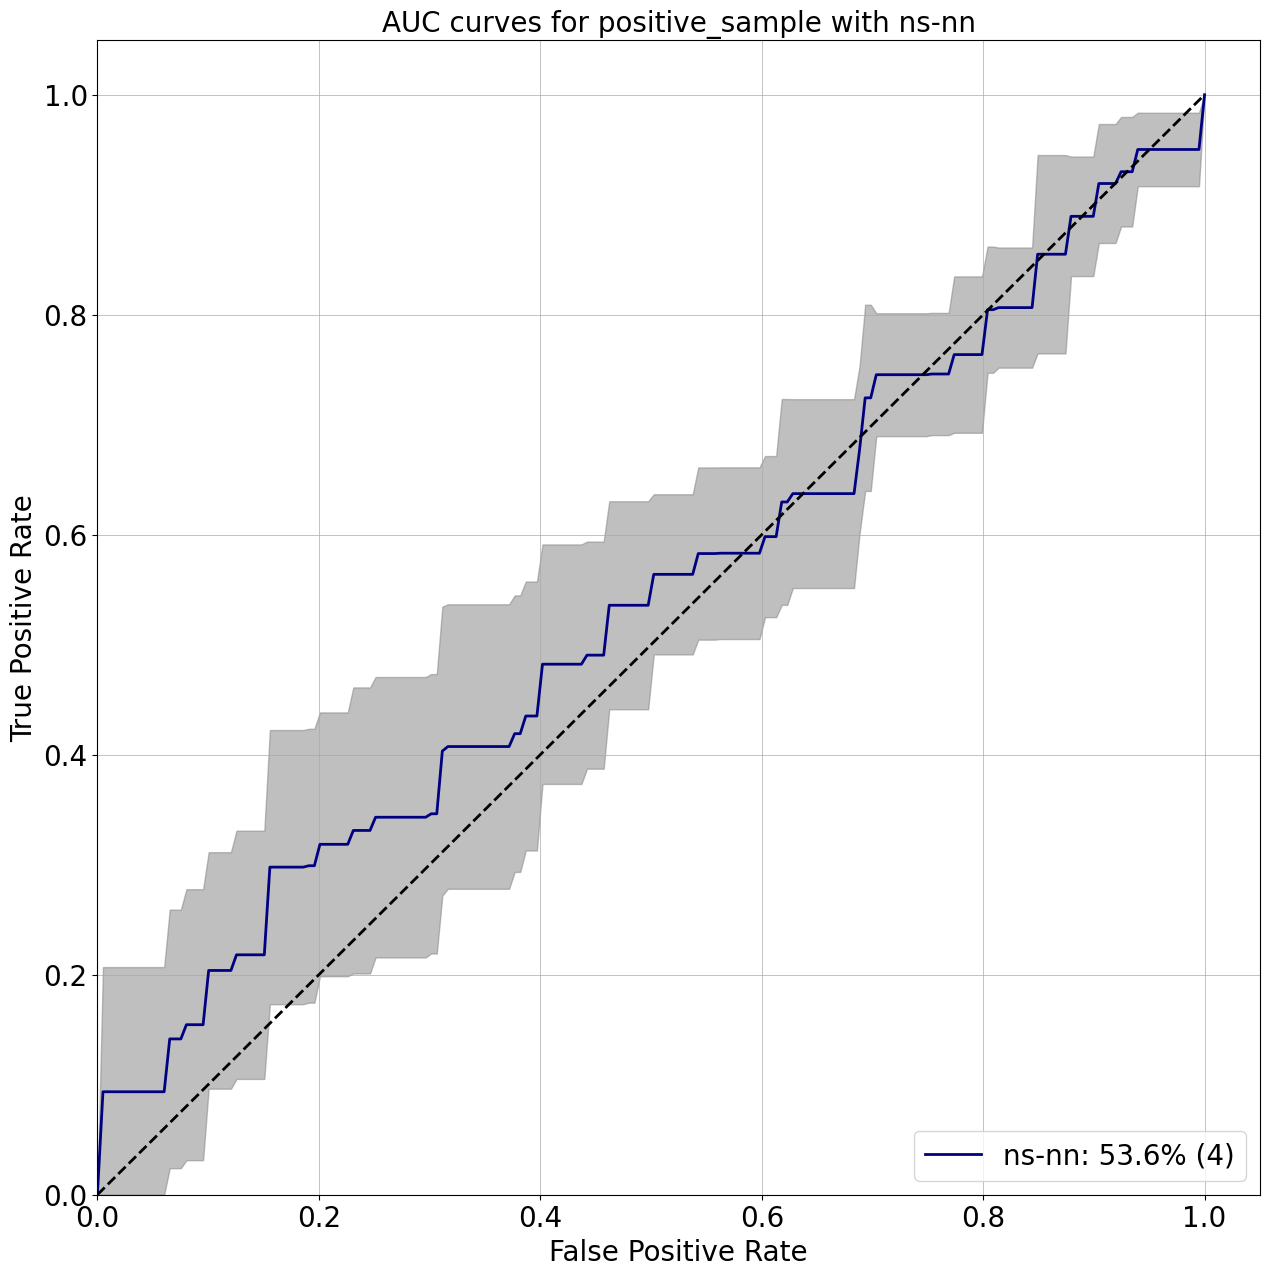

1/1 [==============================] - 0s 41ms/step


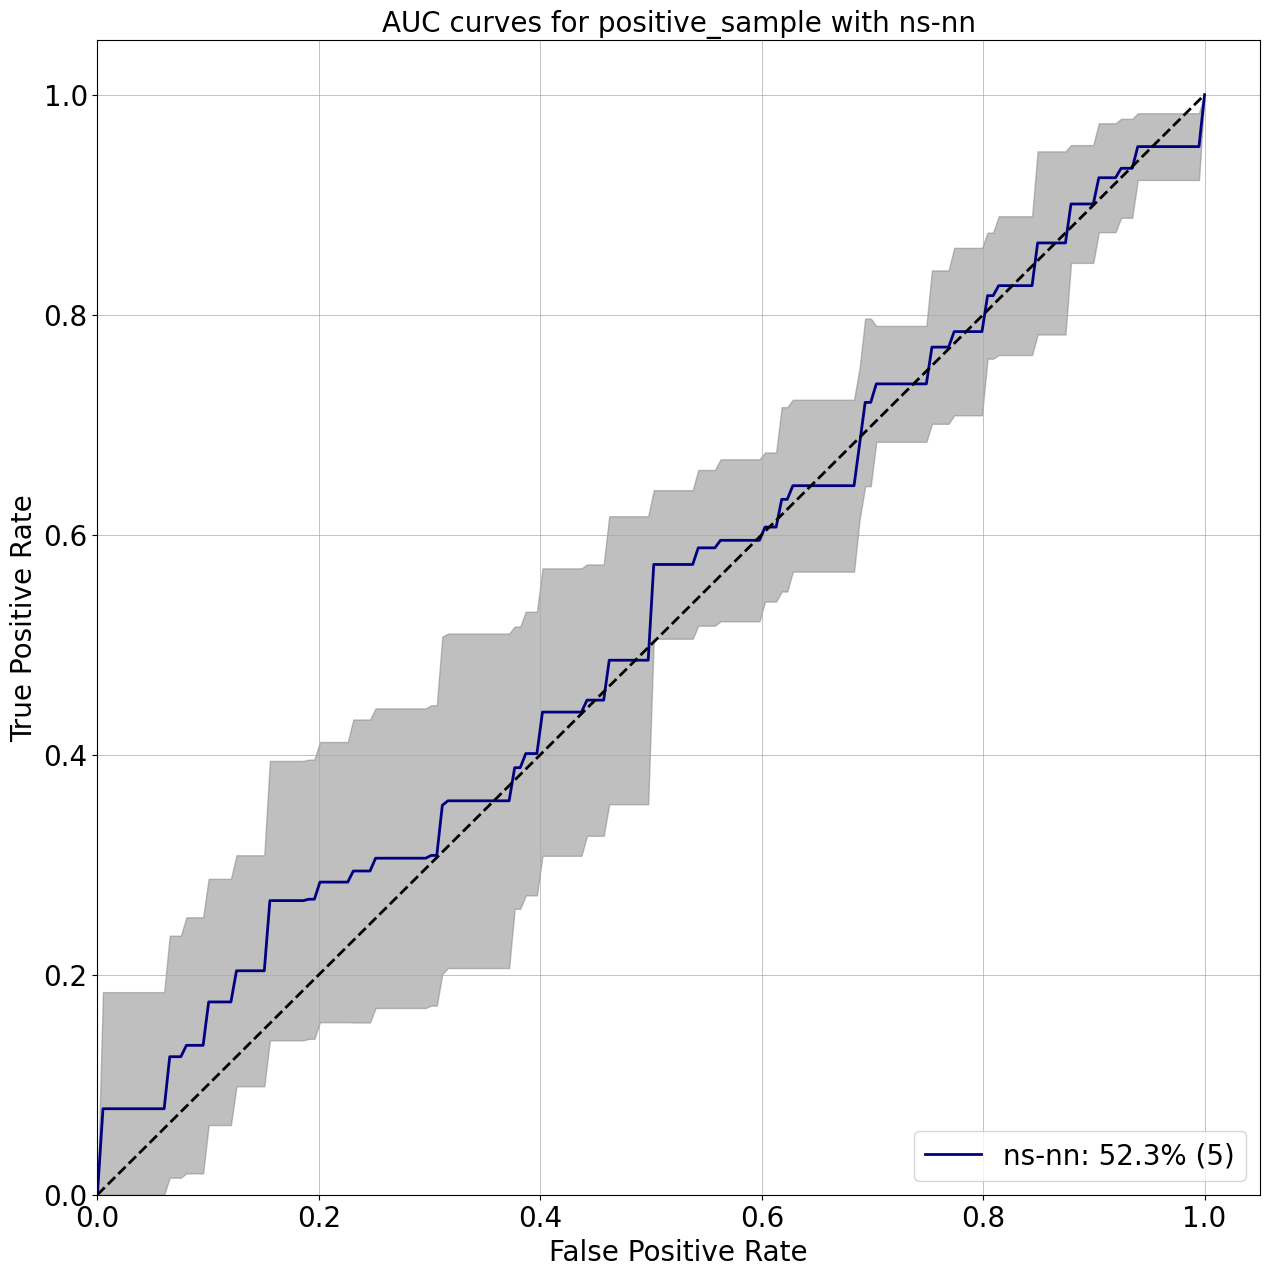

Final Results:
                 ad       auc    extime
000-00-ns-nn  ns-nn  0.464929  1.752833
000-01-ns-nn  ns-nn  0.495180  1.556123
000-02-ns-nn  ns-nn  0.675914  1.668621
000-03-ns-nn  ns-nn  0.507789  1.533601
000-04-ns-nn  ns-nn  0.471835  1.577679


In [5]:
#@title Execute Cross-Fold Validation {output-height:"unlimited"}
number_crossfolds =  1#@param {type:"integer"}
number_folds =  5#@param {type:"integer"}


def fold_sample(sample: pd.DataFrame, n_folds: int = 5) ->  List[Dict[str, pd.DataFrame]]:
  """Splits a sample into N folds.
  
  Args:
    sample: training/test sample to be folded.
  """
  sample = shuffle(sample)
  
  folds = []
  # Split into train and test folds, and assign to list called folds.
  for training_sample_idx, test_sample_idx in KFold(n_splits=5).split(sample):
        test_sample = sample.iloc[test_sample_idx]
        #print(test_sample)
        training_sample = sample.iloc[training_sample_idx]
        folds.append({"train": training_sample, "test": test_sample})
  return folds


def plot_auc(ad_results: Dict[str, Dict[str, Dict[str, np.array]]], 
             experiment_name: str):
  """Plots the ROC AUC. """
  
  fig, ax = plt.subplots(figsize=(15, 15))
  start = 0.0
  stop = 1.0
  colors = [cm.jet(x) for x in np.linspace(start, stop, len(ad_results))]

  df_auc = pd.DataFrame()

  lw = 2
  ix = 0
  for ad_id in ad_results:

    fold_results = ad_results[ad_id]
    vfprs = []
    vtprs = []

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)
    validation_aucs = []
    for fold_id in fold_results:
      fpr = fold_results[fold_id]['fpr']
      tpr = fold_results[fold_id]['tpr']

      validation_auc_val = auc(fpr, tpr)
      validation_aucs.append(validation_auc_val)    
      interp_tpr = np.interp(mean_fpr, fpr, tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
  
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(validation_aucs)
    df_auc[ad_id] = [mean_auc]

    plt.plot(mean_fpr, mean_tpr, color=colors[ix], lw=lw, 
             label='%s: %0.1f%% (%d)' % (
                 ad_id, 100.0 * mean_auc, len(fold_results) ))
    ix+=1

    std_tpr = np.std(tprs, axis=0)
    
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='gray', alpha=0.5,
                label=None)
    
  ax.grid(linestyle='-', linewidth='0.5', color='darkgray')
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.05])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('AUC curves for %s' %experiment_name)
  
  legend = plt.legend(loc='lower right', shadow=False, fontsize='20')
  legend.get_frame().set_facecolor('white')

  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
  
  for sp in ax.spines:
    ax.spines[sp].set_color("black")

  plt.show()

anomaly_detectors = sorted(list(ad_dict))
experiment_name = "%s with %s" %(ds.name, ", ".join(anomaly_detectors))

df_results = pd.DataFrame(columns = ['ad', 'auc', 'extime'])
ad_results = {}

for ad in anomaly_detectors:

  if ad not in ad_results:
    ad_results[ad] = {}

  for cx_run in range(number_crossfolds):
    folds = fold_sample(ds.sample, n_folds = number_folds)

    for fid in range(number_folds):
      
      fold = folds[fid]

      # Drop the class label from the training sample, since this is unsupervised.
      training_sample = fold['train'].copy()
      testing_sample = fold['test'].copy()
      X_train = training_sample.drop(columns = ['class_label'])
      #print(X_train)
      X_test  = testing_sample.drop(columns = ['class_label'])
      y_test  = testing_sample['class_label']
      #print(y_test)

      start_time = time.time()

      # Train a model in the training split.
      ad_dict[ad].train_model(x_train=X_train)

      # Predict on the test set.
      y_predicted = ad_dict[ad].predict(X_test)['class_prob']
      #print(y_predicted)

      # Compute the AUC on the test set. 
      auc_value = madi.utils.evaluation_utils.compute_auc(
              y_actual=y_test, y_predicted=y_predicted)
      #print(auc_value)
        
      # Compute the ROC curve.
      fpr, tpr, _ = roc_curve(y_test, y_predicted)

      end_time = time.time()
      extime = end_time - start_time
      ad_results[ad]['%03d-%02d' %(cx_run, fid)] = {'fpr': fpr, 'tpr':tpr}
      df_results.loc['%03d-%02d-%s' %(cx_run, fid, ad)] = [ad, auc_value, extime]

      # Refresh the output area.
      #clear_output()
      
      plot_auc(ad_results, experiment_name  = experiment_name)
      
      del training_sample
      del testing_sample
print("Final Results:")
print(df_results)

In [6]:
#@title Colab Imports
import sys
import madi
from madi.utils import file_utils
from madi.tests import file_utils_test
import numpy as np
import pandas as pd
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

from madi.datasets import positive_sample_dataset
from madi.tests import gaussian_mixture_dataset_test
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
from madi.tests.neg_sample_neural_net_detector_test import TestNegSampleNeuralNetDetector
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter
from madi.tests.integrated_gradients_interpreter_test import TestIntegratedGradientsInterpreter


import tensorflow as tf
assert tf.version.VERSION > '2.1.0'

In [58]:
#@title Plotting utilities
def plot_attribution(df_attribution: pd.DataFrame, anomaly_score: float) -> None:
    df_attribution = df_attribution.sort_values(by='attribution', ascending=False)
    print(df_attribution)
    norm = plt.Normalize()
    names=[]
    sizes = []
    sum_big = 0
    for fn, row in df_attribution.iterrows():
    # Only show the dimensions with a blame > 5%.
        if row.attribution > 0.05:
            names.append('%s\n%3.1f (%3.1f)' %(fn, row.observed_value, row.expected_value))
            wedge_size = int(100* row.attribution)
            sum_big += wedge_size
            sizes.append(wedge_size)
    names.append('other')
    sizes.append(int(100 - sum_big))

  # Create a circle for the center of the plot
    num_p_score_steps = 100
    center_color_index  = int(num_p_score_steps*anomaly_score)
    my_circle=plt.Circle( (0,0), 0.45, facecolor=plt.cm.RdYlGn(
      norm(range(num_p_score_steps+1)))[center_color_index],
      edgecolor='white', linewidth=3)

    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(10)

    center_text = "%.2f" %(anomaly_score)
    if (center_color_index < 20 ) or (center_color_index > 80):
        text_color = 'black'
    else:
        text_color = 'black'
    ax.text(0,0,center_text, fontsize=28,horizontalalignment='center',
          color=text_color, weight="bold")

      # Custom colors --> colors will cycle
    norm = plt.Normalize()
      # Choose nine colors to cycle through to show contrast between slices.
    pie_plot = plt.pie(sizes, labels=names, colors=plt.cm.RdYlBu(norm(range(9)), alpha=0.6),
                         startangle=90, counterclock=False, autopct='%1.0f%%',
                         pctdistance=0.70, textprops=
                         dict(color="black", weight="bold", fontsize=28))

    for lab in pie_plot[1]:
        lab.set_fontsize(28)
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

def plot_gradient_series(df_grad: pd.DataFrame, delta: np.array) -> None:
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    n_points = len(df_grad)
    colors = sns.color_palette('rainbow', df_grad.shape[1])
    for ix, field_name in enumerate(df_grad):
        series_color = colors[ix]
        ig_series = (df_grad[field_name].cumsum()/float(n_points)) * delta[field_name]
        ax.plot(df_grad.index, ig_series , linewidth=3.0, linestyle='-', marker=None, color=series_color)

    ax.grid(linestyle='-', linewidth='0.5', color='darkgray')

    legend = plt.legend(loc='upper left', shadow=False, fontsize='16', bbox_to_anchor=(1, 1), labels = list(df_grad))
    legend.get_frame().set_facecolor('white')
    plt.ylabel('Cumulative Gradients')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)
    
    for sp in ax.spines:
        ax.spines[sp].set_color("black")
    ax.set_facecolor("white")

    plt.grid(True)
    plt.show()

In [8]:
#@title Choose the data set
_RESOURCE_LOCATION = "madi.datasets.data"
data_source = "positive_sample" #@param ["gaussian_mixture", "smart_buildings"]
ds = None

class InvalidDatasetError(ValueError):
    pass

if data_source == 'positive_sample':
  data_file = file_utils.PackageResource(
      _RESOURCE_LOCATION, "positive_sample.csv")
  readme_file = file_utils.PackageResource(
      _RESOURCE_LOCATION, "positive_sample_README.md")
  ds = madi.datasets.positive_sample_dataset.PositiveSampleDataset(data_file, readme_file)
  print(ds.description)

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)


print('Randomize the data, and split into training and test sample.')
split_ix = int(len(ds.sample) * 0.8)
training_sample = ds.sample.iloc[:split_ix]
test_sample = ds.sample.iloc[split_ix:]
print("\tTraining sample size: %d" %len(training_sample))
print("\tTest sample size: %d" %len(test_sample))

The positive sample dataset consists of 4,032 multidimensional observations. 
 The dataset consists of 4032 rows and seven columns. 
 These are the test dataset that we will be using in this project.

Randomize the data, and split into training and test sample.
	Training sample size: 3225
	Test sample size: 807


In [53]:
#@title Train a Negative Sampling Neural Net (NS-NN) Anomaly Detector
log_dir = "logs/nsnn2" #@param {type:"string"}

nsnn_params = {}

if data_source == 'positive_sample':
    nsnn_params['sample_ratio']=3.0
    nsnn_params['sample_delta']=0.05
    nsnn_params['batch_size']=32
    nsnn_params['steps_per_epoch']=16
    nsnn_params['epochs']=20
    nsnn_params['dropout']=0.5
    nsnn_params['layer_width']=64
    nsnn_params['n_hidden_layers']=2

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)

print(nsnn_params)
X_train = training_sample.drop(columns = ['class_label'])
print(X_train)

# It's very important to normalize the data for both classification and
# anomaly detection.
y_train = training_sample['class_label']
print(y_train)

# We shall reuse the normalization info from training for test.
X_test = test_sample.drop(columns = ['class_label'])
print(X_test)
y_test= test_sample['class_label']
print(y_test)

# Declare the AD and parameterize it.
ad = NegativeSamplingNeuralNetworkAD(
        sample_ratio=nsnn_params['sample_ratio'],
        sample_delta=nsnn_params['sample_delta'],
        batch_size=nsnn_params['batch_size'],
        steps_per_epoch=nsnn_params['steps_per_epoch'],
        epochs=nsnn_params['epochs'],
        dropout=nsnn_params['dropout'],
        layer_width=nsnn_params['layer_width'],
        n_hidden_layers=nsnn_params['n_hidden_layers'],
        log_dir=log_dir)
print(ad)
# Build the sample and train the AD classifier model.
ad.train_model(x_train=X_train)

xy_predicted = ad.predict(X_test)

auc = madi.utils.evaluation_utils.compute_auc(
      y_actual=y_test, y_predicted=xy_predicted['class_prob'])
print(auc)
print("The AUC against the test set is %0.3f" %auc)

{'sample_ratio': 3.0, 'sample_delta': 0.05, 'batch_size': 32, 'steps_per_epoch': 16, 'epochs': 20, 'dropout': 0.5, 'layer_width': 64, 'n_hidden_layers': 2}
               x002      x003      x004      x005      x006      x007  \
x001                                                                    
-3.480021  1.147650 -1.333065  0.649377 -5.394574 -3.777475 -1.339321   
-2.148262 -3.713053 -2.622108 -2.945906 -1.824657 -1.964783 -2.042662   
 1.288694  2.843224  2.897933  2.310915  2.386191  2.200860  2.708330   
 2.548701  1.682945  2.813261  2.098966  2.097696  2.168417  2.752283   
-1.182073 -2.213148 -2.064556 -2.937915 -2.183885 -2.174799 -1.889320   
...             ...       ...       ...       ...       ...       ...   
-2.080766 -1.487319 -3.359222 -2.733982 -2.678207 -3.470835 -1.201133   
 3.845636  2.631343  2.801517  1.908121  2.824967  2.845063  2.810093   
-3.477867 -4.327225  2.724748  0.586427 -5.940463  4.973601 -3.987784   
 1.977017  3.500039  3.639944  2.437756  

In [55]:

#@title Set up the anomaly interpreter.


min_class_confidence = 0.99 #@param {type:"number"}
max_baseline_size = 500 #@param {type:"integer"}

try:
  X_train_normalized = madi.utils.sample_utils.normalize(X_train, ad._normalization_info)
  interpreter = madi.detectors.integrated_gradients_interpreter.IntegratedGradientsInterpreter(
          ad._model, X_train_normalized,
          min_class_confidence, max_baseline_size,num_steps_integrated_gradients = 2000)
  print('Variable Attibution is ready with a baseline sample size of %d points.' %len(interpreter._df_baseline))
except madi.detectors.integrated_gradients_interpreter.NoQualifyingBaselineError as err:
  print(err.message)
  print('Assign min_class_confidence to a value below %0.2f to accumulate a baseline sample.' %err.highest_class_confidence)
  print('Variable Attibution is NOT ready.')

1/1 [==============================] - 0s 38ms/step
Variable Attibution is ready with a baseline sample size of 2 points.


In [56]:
#@title Generate the sliders for interactive control.

def get_variable_slider(variable_name:str, mean:float, std:float, default:float) -> str:
  if "percent" in variable_name:
    min_val = 0
    max_val = 100
    step = 1
  elif "temperature" in variable_name:
    min_val = 250
    max_val = 350
    step = 1
  elif variable_name == "dow":
    min_val = 0
    max_val = 6
    step = 1
  elif variable_name == "hod":
    min_val = 0
    max_val = 23
    step = 1
  else:
    min_val = mean - 6 * std
    max_val = mean + 6 * std
    step = (max_val - min_val)/100.0

  var_name_base = variable_name.replace("data:", "")
  return """%s = %f #%sparam {type:"slider", min:%f, max:%f, step:%f}""" %(var_name_base, default, "@", min_val, max_val, step )

def get_var_assignment(variable_name: str) -> str:
  var_name_base = variable_name.replace("data:", "")
  return """observed_point['%s'] = [%s]""" %(variable_name, var_name_base)

def get_sliders(normalization_info: Dict[str, madi.utils.sample_utils.Variable], baseline: pd.DataFrame):
  column_order = madi.utils.sample_utils.get_column_order(normalization_info)
  slider_strings  = []
  for col in column_order:
    slider_strings.append(get_variable_slider(col, normalization_info[col].mean, normalization_info[col].std, baseline[col]))
  return "\n".join(slider_strings)

def get_var_assignments(normalization_info):
  column_order = madi.utils.sample_utils.get_column_order(normalization_info)
  assignment_strings  = []
  for col in column_order:
    assignment_strings.append(get_var_assignment(normalization_info[col].name))
  return "\n".join(assignment_strings)

df_reference_point_selected_normalized = interpreter._df_baseline.iloc[[0]]
df_reference_point_selected =madi.utils.sample_utils.denormalize(df_reference_point_selected_normalized, ad._normalization_info)

print(get_sliders(ad._normalization_info,df_reference_point_selected.iloc[0]))
print(get_var_assignments(ad._normalization_info))

x002 = -2.060886 #@param {type:"slider", min:-15.454991, max:15.419296, step:0.308743}
x003 = -2.699448 #@param {type:"slider", min:-15.329597, max:15.283326, step:0.306129}
x004 = -3.233997 #@param {type:"slider", min:-15.336161, max:15.253270, step:0.305894}
x005 = -1.790541 #@param {type:"slider", min:-15.359888, max:15.320353, step:0.306802}
x006 = -3.136652 #@param {type:"slider", min:-15.271953, max:15.281319, step:0.305533}
x007 = -2.994850 #@param {type:"slider", min:-15.315414, max:15.298688, step:0.306141}
x008 = -2.412998 #@param {type:"slider", min:-15.515306, max:15.459494, step:0.309748}
x009 = -2.418298 #@param {type:"slider", min:-15.300977, max:15.213630, step:0.305146}
x010 = -3.125860 #@param {type:"slider", min:-15.371116, max:15.307700, step:0.306788}
x011 = -3.600831 #@param {type:"slider", min:-15.402687, max:15.281873, step:0.306846}
x012 = -3.216704 #@param {type:"slider", min:-15.236394, max:15.171710, step:0.304081}
x013 = -2.980489 #@param {type:"slider", mi

If you're getting an error, please open this cell and paste the output from the last cell here.
1/1 [==============================] - 0s 16ms/step
      observed_value  expected_value  attribution
x009       -2.418298       -2.418298     0.209193
x007       -2.994850       -2.994850     0.162189
x016       -2.743247       -2.743247     0.159519
x008       -2.412998       -2.412998     0.140866
x011       -3.600831       -3.600831     0.099175
x005       -1.790541       -1.790541     0.077470
x002       -2.060886       -2.060886     0.031155
x012       -3.216704       -3.216704     0.029590
x013       -2.980489       -2.980489     0.027574
x006       -3.136652       -3.136652     0.024894
x015       -2.976178       -2.976178     0.013323
x010       -3.125860       -3.125860     0.012646
x004       -3.233997       -3.233997     0.008962
x014       -3.162112       -3.162112     0.003113
x003       -2.699448       -2.699448     0.000332


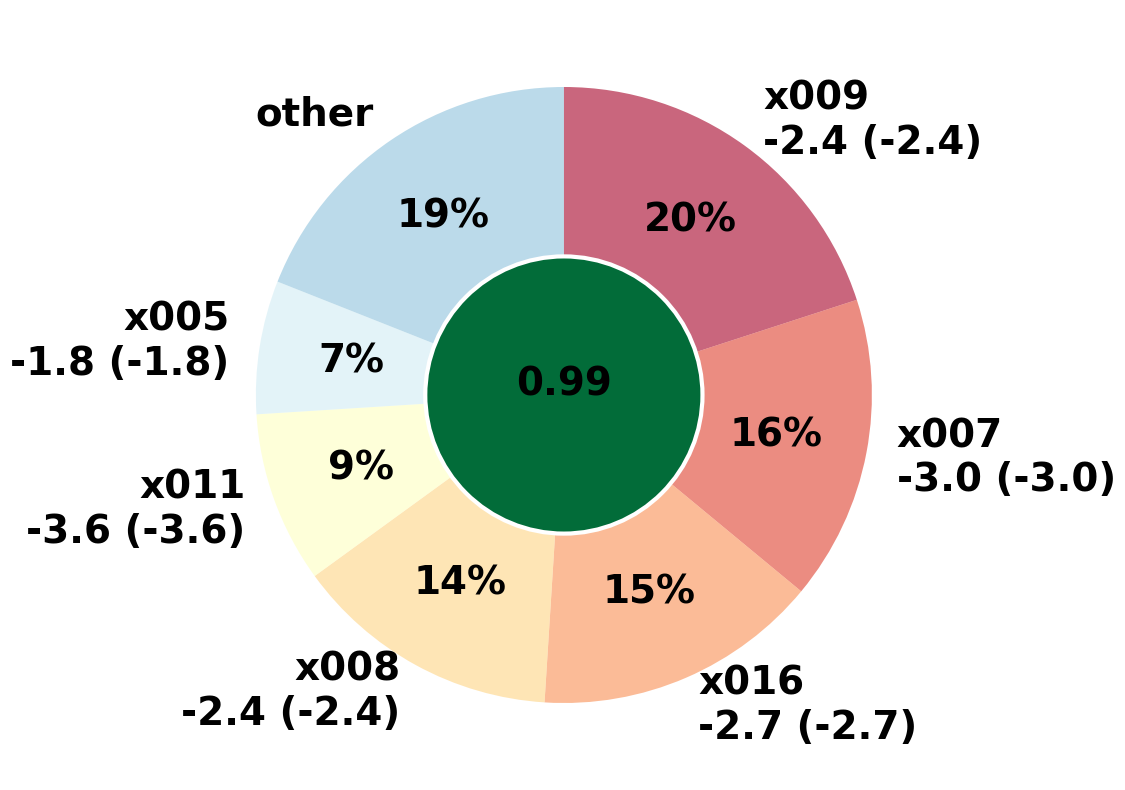

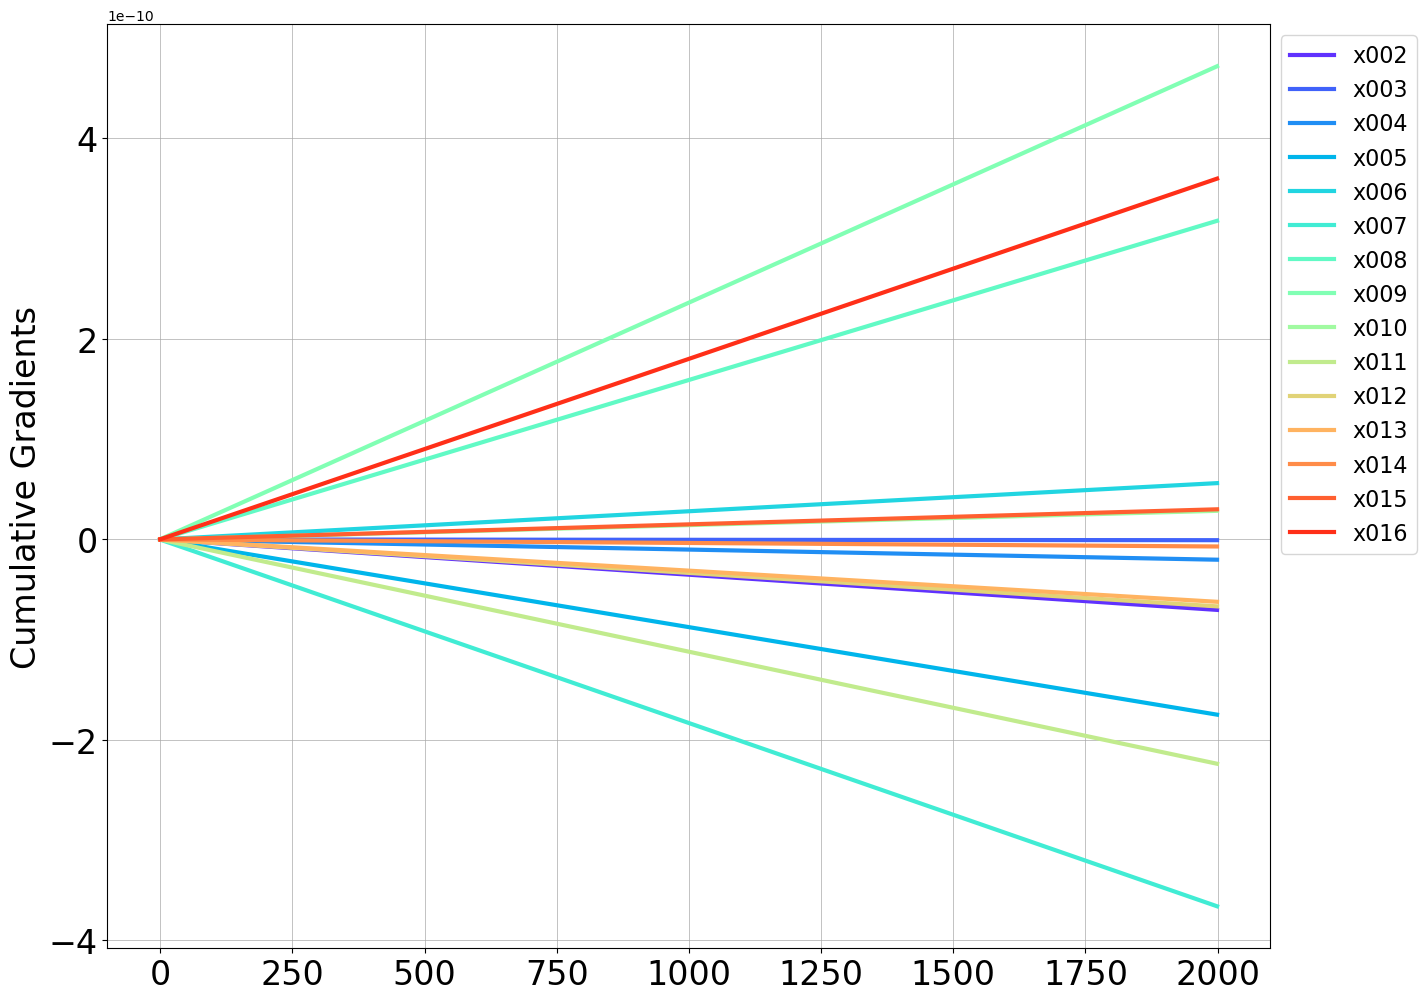

In [59]:
#@title Visualize variable attribution. { vertical-output: false, run: "auto" }

np.set_printoptions(threshold=sys.maxsize)
column_order = madi.utils.sample_utils.get_column_order(ad._normalization_info)
observed_point = {}

################################################################
#vv Copy and paste the text from the cell into the area below.vv
################################################################
print('If you\'re getting an error, please open this cell and paste the output from the last cell here.')
# Sliders should look similar to this:
# zone_air_heating_temperature_setpoint = 285.925926 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
# zone_air_temperature_sensor = 272 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
# zone_air_cooling_temperature_setpoint = 267 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
# supply_air_flowrate_sensor = -0.001365 #@param {type:"slider", min:-0.525120, max:0.680106, step:0.012052}
# supply_air_damper_percentage_command = 100.000000 #@param {type:"slider", min:0.000000, max:100.000000, step:1.000000}
# supply_air_flowrate_setpoint = 0.035396 #@param {type:"slider", min:-0.458984, max:0.618622, step:0.010776}
# dow = 6.000000 #@param {type:"slider", min:0.000000, max:6.000000, step:1.000000}
# hod = 0.000000 #@param {type:"slider", min:0.000000, max:23.000000, step:1.000000}
# observed_point['data:zone_air_heating_temperature_setpoint'] = [zone_air_heating_temperature_setpoint]
# observed_point['data:zone_air_temperature_sensor'] = [zone_air_temperature_sensor]
# observed_point['data:zone_air_cooling_temperature_setpoint'] = [zone_air_cooling_temperature_setpoint]
# observed_point['data:supply_air_flowrate_sensor'] = [supply_air_flowrate_sensor]
# observed_point['data:supply_air_damper_percentage_command'] = [supply_air_damper_percentage_command]
# observed_point['data:supply_air_flowrate_setpoint'] = [supply_air_flowrate_setpoint]
# observed_point['dow'] = [dow]
# observed_point['hod'] = [hod]
x002 = -2.060886 #@param {type:"slider", min:-15.454991, max:15.419296, step:0.308743}
x003 = -2.699448 #@param {type:"slider", min:-15.329597, max:15.283326, step:0.306129}
x004 = -3.233997 #@param {type:"slider", min:-15.336161, max:15.253270, step:0.305894}
x005 = -1.790541 #@param {type:"slider", min:-15.359888, max:15.320353, step:0.306802}
x006 = -3.136652 #@param {type:"slider", min:-15.271953, max:15.281319, step:0.305533}
x007 = -2.994850 #@param {type:"slider", min:-15.315414, max:15.298688, step:0.306141}
x008 = -2.412998 #@param {type:"slider", min:-15.515306, max:15.459494, step:0.309748}
x009 = -2.418298 #@param {type:"slider", min:-15.300977, max:15.213630, step:0.305146}
x010 = -3.125860 #@param {type:"slider", min:-15.371116, max:15.307700, step:0.306788}
x011 = -3.600831 #@param {type:"slider", min:-15.402687, max:15.281873, step:0.306846}
x012 = -3.216704 #@param {type:"slider", min:-15.236394, max:15.171710, step:0.304081}
x013 = -2.980489 #@param {type:"slider", min:-15.340681, max:15.378074, step:0.307188}
x014 = -3.162112 #@param {type:"slider", min:-15.350215, max:15.231062, step:0.305813}
x015 = -2.976178 #@param {type:"slider", min:-15.317378, max:15.289331, step:0.306067}
x016 = -2.743247 #@param {type:"slider", min:-15.360984, max:15.300010, step:0.306610}
observed_point['x002'] = [x002]
observed_point['x003'] = [x003]
observed_point['x004'] = [x004]
observed_point['x005'] = [x005]
observed_point['x006'] = [x006]
observed_point['x007'] = [x007]
observed_point['x008'] = [x008]
observed_point['x009'] = [x009]
observed_point['x010'] = [x010]
observed_point['x011'] = [x011]
observed_point['x012'] = [x012]
observed_point['x013'] = [x013]
observed_point['x014'] = [x014]
observed_point['x015'] = [x015]
observed_point['x016'] = [x016]
################################################################
#^^ Copy and paste the text from the cell into the area above.^^
################################################################

# Get the observed point from the sliders:
df_observed_point = pd.DataFrame(observed_point)

# Since the sliders are shown in orgininal spaces, we should normalize:
df_observed_point_normalized = madi.utils.sample_utils.normalize(df_observed_point, ad._normalization_info)

# Get the anomaly score from the NSNN.
anomaly_score = ad.predict(df_observed_point.copy())['class_prob'][0]

# Call the Blame method that applies Integrated Gradients.
attribution_dict, reference_point_dict, df_grad = interpreter.blame(df_observed_point_normalized.iloc[0])
attribution = pd.Series(attribution_dict)
nearest_reference_point_normalized = pd.Series(reference_point_dict)
df_nearest_reference_point_normalized = nearest_reference_point_normalized.to_frame().T
df_nearest_reference_point = madi.utils.sample_utils.denormalize(df_nearest_reference_point_normalized, ad._normalization_info)
df_attribution = pd.concat([df_observed_point.iloc[0], df_nearest_reference_point.iloc[0], attribution], axis = 1,
                           keys=['observed_value', 'expected_value', 'attribution'], sort = True)

plot_attribution(df_attribution, anomaly_score)

# Plot the attribution as a cumulative curve from reference to observed.
# Use the normalized difference, b/c the model and its gradients are based on
# normalized training data.
delta_normalized = df_nearest_reference_point_normalized.iloc[0] - df_observed_point_normalized.iloc[0]
colnames  = {}
column_order = madi.utils.sample_utils.get_column_order(ad._normalization_info)
for i in range(len(column_order)):
  colnames[i] = column_order[i]

df_grad.set_axis(column_order, axis=1, inplace=True)
plot_gradient_series(df_grad, delta_normalized)

# TODO(sipple) from review:
# Particularly for smart buildings, it would be cool to have the option to see
# the attributions and the cumulative gradients for an anomaly, something like:
# EXAMPLE_TYPE = 'reference point' #@param ['reference point', 'anomaly']

# if EXAMPLE_TYPE == 'reference point':
#   df_reference_point_selected_normalized = interpreter._df_baseline.sample(1)
#   df_point_selected = madi.utils.sample_utils.denormalize(df_reference_point_selected_normalized, ad._normalization_info)
# elif EXAMPLE_TYPE == 'anomaly':
#   df_point_selected = test_sample[test_sample.class_label == 0].sample(1)
# else:
#   raise NotImplementedError